# Analyzing the Trends in Ratings of Complete TV Shows
---

In [53]:
# import libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import random

In [211]:
# configure matplotlib
plt.rcParams["figure.figsize"] = 15,10

## Collecting Data From IMDB
---

### Extracting a List of TV Shows

In [133]:
def show_data_extract(page):
    """
    Extract the details of tv shows on an IMDB list
    """
    # send get request
    response = requests.get(page)

    # parse through beautiful soup
    soup = BeautifulSoup(response.content)
    
    # get all shows listed
    listed = soup.find_all("div", attrs={"class": "lister-item-content"})

    # to store all show data
    all_shows_data = []

    # iterate through each show in the list extracting details
    for show in listed:
        # get header
        title = show.find("a").text

        # get relative link on imdb
        rel_link = show.find("a").get("href")

        # get show duration
        duration = show.find("span", attrs={"class": "lister-item-year text-muted unbold"}).text.strip()

        # get runtime
        runtime = show.find("span", attrs={"class": "runtime"}).text.strip()

        # get genre
        genre = show.find("span", attrs={"class": "genre"}).text.strip()

        # get overall rating
        overall_rating = show.find("div", attrs={"class": "inline-block ratings-imdb-rating"}).text.strip()
        
        # get number of ratings
        rating_num = show.find("meta", attrs={"itemprop": "ratingCount"}).get("content")

        # store
        all_shows_data.append({
            "title": title,
            "rel_link": rel_link,
            "duration": duration,
            "runtime": runtime,
            "genre": genre,
            "overall_rating": overall_rating,
            "rating_num": rating_num
        })
    
    return all_shows_data

In [134]:
# three pages of a list of 126 tv shows with more than 100,000 ratings
shows_url_page_1 = r"https://www.imdb.com/search/title?title_type=tv_series" \
                    "&num_votes=100000,&sort=user_rating,desc&view=advanced"

shows_url_page_2 = r"https://www.imdb.com/search/title?title_type=tv_series&" \
                    "num_votes=100000,&sort=user_rating,desc&start=51&ref_=adv_nxt"

shows_url_page_3 = r"https://www.imdb.com/search/title?title_type=tv_series&" \
                    "num_votes=100000,&sort=user_rating,desc&start=101&ref_=adv_nxt"

In [135]:
# to store the details of the tv shows on each page
tv_shows = pd.DataFrame()

# parse each of the pages of the list
for page in [shows_url_page_1, shows_url_page_2, shows_url_page_3]:
    # extract show data and store in the df created above
    tv_shows = tv_shows.append(show_data_extract(page), sort=True)
    
    # pause so we don't overload IMDB's servers
    time.sleep(3)

In [137]:
# turn imdb relative links into absolute links
tv_shows = tv_shows.assign(abs_link = tv_shows["rel_link"].apply(lambda x: "https://www.imdb.com" + x))

In [138]:
# based on the duration, mark shows as complete or ongoing
# (shortcut: if the second digit from the last is an empty space and not a number, it's not complete)
tv_shows = tv_shows.assign(status = tv_shows["duration"].apply(lambda x: x[-2].isdigit()))

In [139]:
# backup the complete list of tv shows
tv_shows.to_csv("tv_shows.csv", index=False, encoding="utf-8")

In [140]:
# filter down to a list of completed tv show
complete_shows = tv_shows[tv_shows.status == True]

In [141]:
# reset index
complete_shows = complete_shows.reset_index(drop=True)

### Extracting the Ratings of All Episodes of Each TV Show

In [250]:
def episode_data_extract(page, show):
    """
    Extract episodes from all season pages for an IMDB show
    """
    # form url of first episodes page
    ratings_page = f"{page}episodes"
    
    # send get request
    try:
        response = requests.get(ratings_page)
    # if it fails, pause and try again
    except:
        time.sleep(10)
        response = requests.get(ratings_page)
    
    # parse with bs4
    soup = BeautifulSoup(response.content, "html.parser")
    
    # get number of seasons from drop down (remove seasons with no number i.e., bonus stuff)
    num_of_seasons = max([int(x) for x in soup.find("select", attrs={"id": "bySeason"}).text.split() if x.isdigit()])
    
    # create list to store all episode information
    all_episode_info = []
    
    # pause to prevent overloading servers
    time.sleep(2)
    
    # go through all season pages extracting episode data
    for season_num in range(1,num_of_seasons+1):
        # for url of season page
        season_page = f"{page}episodes?season={season_num}"
        
        # send get request
        try:
            response = requests.get(season_page)
        # if it fails pause and try again
        except:
            time.sleep(10)
            response = requests.get(season_page)
        
        # parse with bs4
        soup = BeautifulSoup(response.content, "html.parser")
        
        # get list of all episodes
        episodes = soup.find_all("div", attrs={"itemprop": "episodes"})
        
        # iterate through list extracting data
        for episode in episodes:
            # get title
            title = episode.find("a", attrs={"itemprop": "name"}).text

            # get episode relative link
            rel_link = episode.find("a", attrs={"itemprop": "name"}).get("href")
            
            # get the episode date
            episode_date = episode.find("div", attrs={"class": "airdate"}).text.strip()

            # get episode rating
            try:
                rating = episode.find("span", attrs={"class": "ipl-rating-star__rating"}).text
            except:
                rating = "Unrated"

            # get number of votes
            try:
                votes = episode.find("span", attrs={"class": "ipl-rating-star__total-votes"}).text
            except:
                votes = "Unrated"

            # get episode number
            episode_number = episode.find("meta", attrs={"itemprop": "episodeNumber"}).get("content")
            
            # store all data
            all_episode_info.append({
                "show": show,
                "season_num": season_num,
                "title": title,
                "rel_link": rel_link,
                "episode_date": episode_date,
                "rating": rating,
                "votes": votes,
                "episode_number": episode_number
            })
            
        # pause before proceeding to the next season
        print(f"{show} -- Season {season_num} complete!")
        time.sleep(3)
    
    return all_episode_info

In [ ]:
# to store all episode information
episode_ratings = pd.DataFrame()

In [252]:
# iterate through all shows extracting the ratings of all epsiodes across all seasons
for show_details in complete_shows.iterrows():
    # skip shows we already extracted (use when program crashes)
    if show_details[0] in [x for x in range(0,36)]:
        continue
    
    # get name and imdb link of show
    show_name = show_details[1].title
    page = show_details[1].abs_link
    
    # extract and store episode data
    episode_ratings = episode_ratings.append(episode_data_extract(page, show_name), sort=True)
    
    # backup so we don't lose all our data in case something happens
    episode_ratings.to_csv("episodes_backup.csv", index=False, encoding="utf-8")
    
    # pause before proceeding to next show
    time.sleep(2)

Prison Break -- Season 1 complete!
Prison Break -- Season 2 complete!
Prison Break -- Season 3 complete!
Prison Break -- Season 4 complete!
Prison Break -- Season 5 complete!
Prison Break -- Season 6 complete!
Lost -- Season 1 complete!
Lost -- Season 2 complete!
Lost -- Season 3 complete!
Lost -- Season 4 complete!
Lost -- Season 5 complete!
Lost -- Season 6 complete!
Scrubs -- Season 1 complete!
Scrubs -- Season 2 complete!
Scrubs -- Season 3 complete!
Scrubs -- Season 4 complete!
Scrubs -- Season 5 complete!
Scrubs -- Season 6 complete!
Scrubs -- Season 7 complete!
Scrubs -- Season 8 complete!
Scrubs -- Season 9 complete!
24 -- Season 1 complete!
24 -- Season 2 complete!
24 -- Season 3 complete!
24 -- Season 4 complete!
24 -- Season 5 complete!
24 -- Season 6 complete!
24 -- Season 7 complete!
24 -- Season 8 complete!
The Originals -- Season 1 complete!
The Originals -- Season 2 complete!
The Originals -- Season 3 complete!
The Originals -- Season 4 complete!
The Originals -- Season

Two and a Half Men -- Season 3 complete!
Two and a Half Men -- Season 4 complete!
Two and a Half Men -- Season 5 complete!
Two and a Half Men -- Season 6 complete!
Two and a Half Men -- Season 7 complete!
Two and a Half Men -- Season 8 complete!
Two and a Half Men -- Season 9 complete!
Two and a Half Men -- Season 10 complete!
Two and a Half Men -- Season 11 complete!
Two and a Half Men -- Season 12 complete!
Glee -- Season 1 complete!
Glee -- Season 2 complete!
Glee -- Season 3 complete!
Glee -- Season 4 complete!
Glee -- Season 5 complete!
Glee -- Season 6 complete!
Iron Fist -- Season 1 complete!
Iron Fist -- Season 2 complete!


In [258]:
# check if there are any duplicates that need to be dropped
len(episode_ratings) == len(episode_ratings.drop_duplicates())

True

In [302]:
# drop all episodes with an unrated rating (most likely to be upcoming episode placeholders)
only_rated = episode_ratings[episode_ratings.rating != "Unrated"]

In [303]:
# change var types
only_rated = only_rated.assign(formatted_date = pd.to_datetime(only_rated.episode_date))
only_rated.rating = only_rated.rating.astype("float")
only_rated = only_rated.assign(formatted_votes = only_rated.votes.apply(lambda x: int(x[1:-1].replace(",", ""))))

In [305]:
# make backup
only_rated.to_csv("only_rated_episodes.csv", index=False, encoding="utf-8")

## Analyzing the Data

---

In [147]:
# import backups

# tv shows
tv_shows = pd.read_csv("tv_shows.csv")
complete_shows = tv_shows[tv_shows.status == True]
complete_shows = complete_shows.reset_index(drop=True)

# episode ratings
only_rated = pd.read_csv("only_rated_episodes.csv", parse_dates=True)
only_rated = only_rated.assign(formatted_date = pd.to_datetime(only_rated.episode_date))

In [148]:
# calculate the average rating per season for each tv show
season_avg = only_rated.groupby(["show", "season_num"])["rating"].mean().reset_index()

### Average Ratings Per Season for the Top 20 TV Shows (By Overall Rating)

In [149]:
# get top 20 tv shows
top20_tv = complete_shows.sort_values("overall_rating", ascending=False)["title"].iloc[:20].tolist()

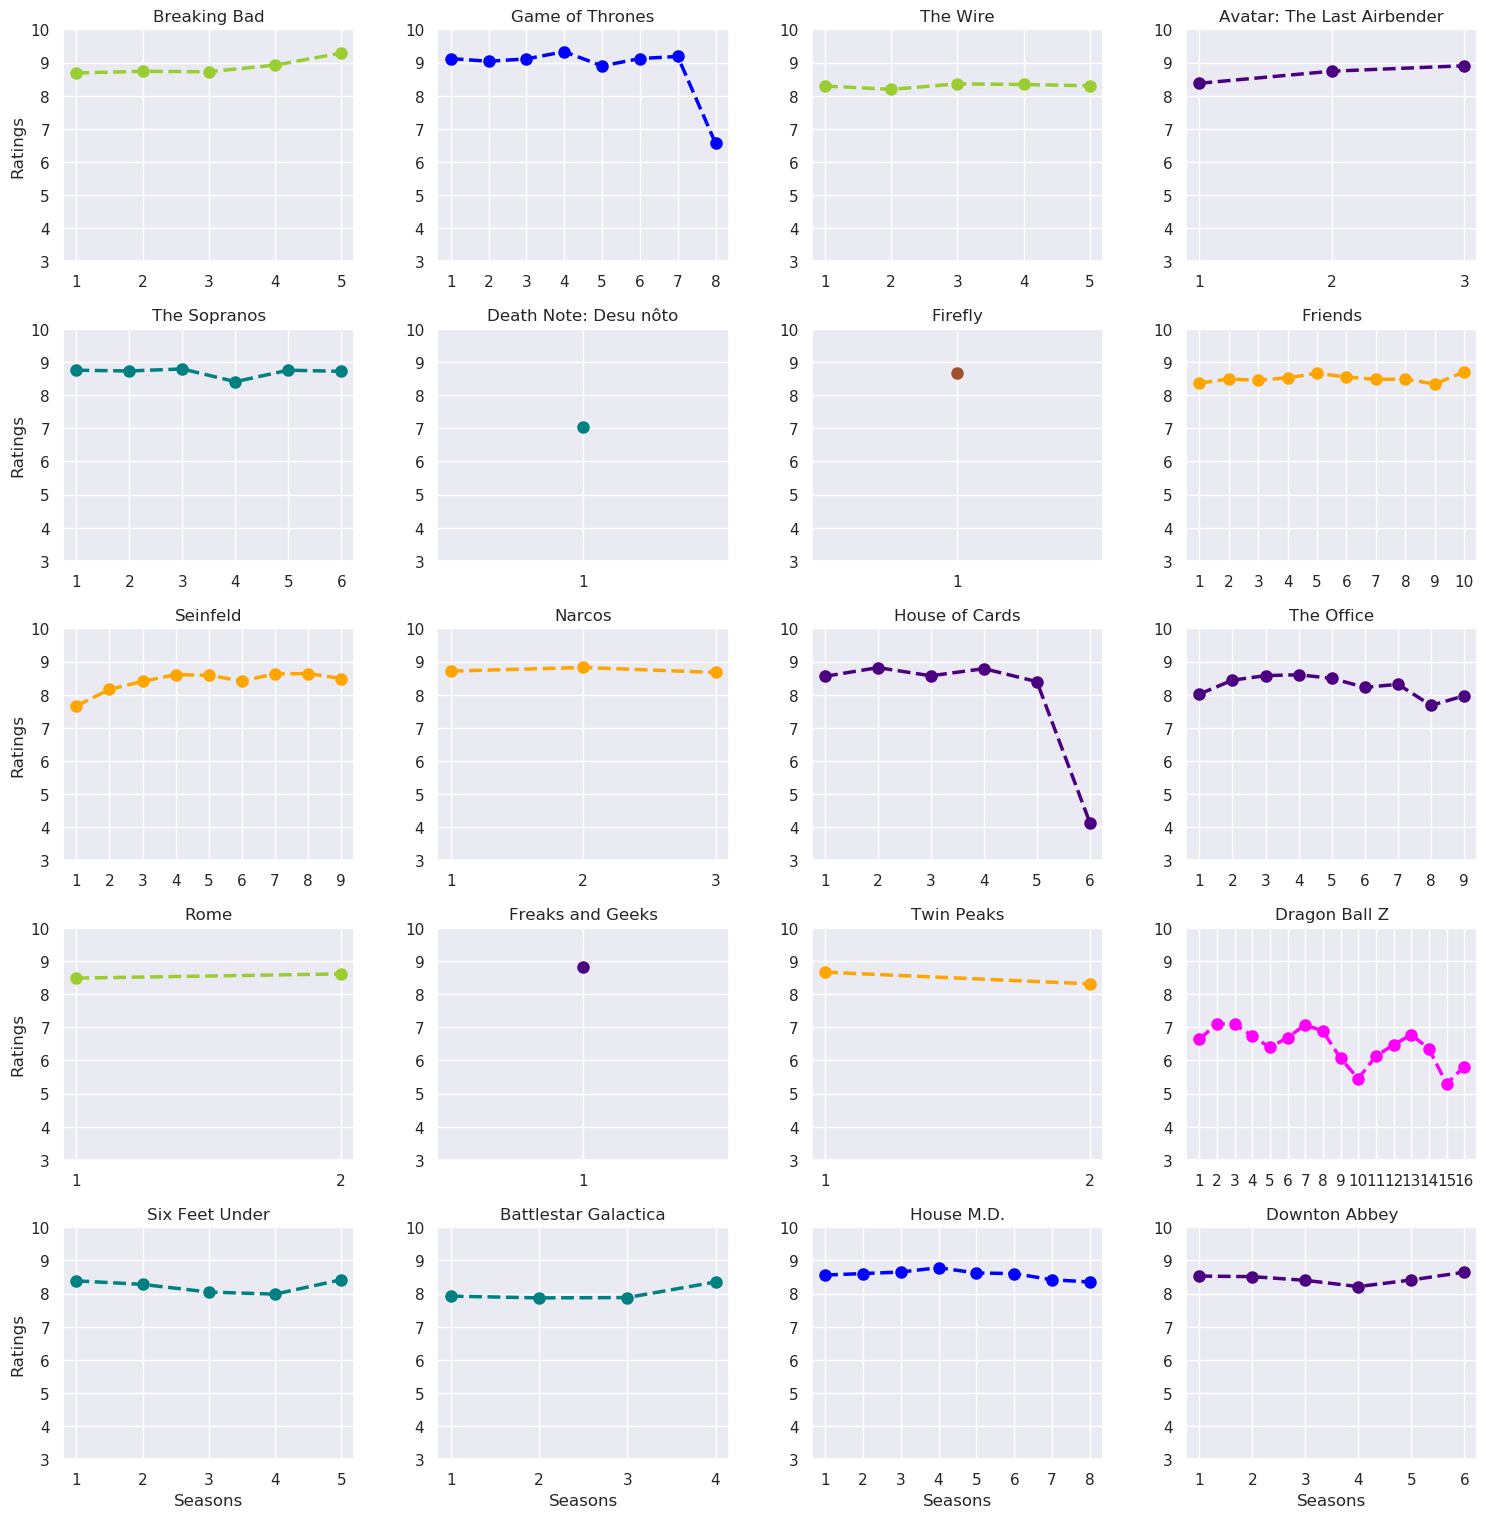

In [150]:
# plot the average rating per season for all shows

# setup
sns.set_style("darkgrid")
sns.set_context("notebook")
f, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,15))
ax = ax.ravel()
f.tight_layout(
    h_pad=2,
    w_pad=2
)

# plot the 20
for pos, show in enumerate(top20_tv):
    # plot
    ax[pos].plot(
        season_avg[season_avg.show == show].season_num.tolist(),
        season_avg[season_avg.show == show].rating.tolist(),
        ls="--",
        lw=2.5,
        marker="o",
        ms=8,
        color=random.choice(["red","blue","indigo","magenta","orange","sienna","teal","yellowgreen"])
    )
    
    # label
    ax[pos].set_title(show)
    ax[pos].set_xticks(season_avg[season_avg.show == show].season_num.tolist())
    ax[pos].set_yticks(range(3,11))
    if pos in [0,4,8,12,16]:
        ax[pos].set_ylabel("Ratings")
    if pos in [16,17,18,19]:
        ax[pos].set_xlabel("Seasons")

# show
plt.show()

### Average Ratings Per Season for the Bottom 20 TV Shows (By Overall Rating)

In [151]:
# get bottom 20 tv shows
bottom20_tv = complete_shows.sort_values("overall_rating", ascending=True)["title"].iloc[:20].tolist()

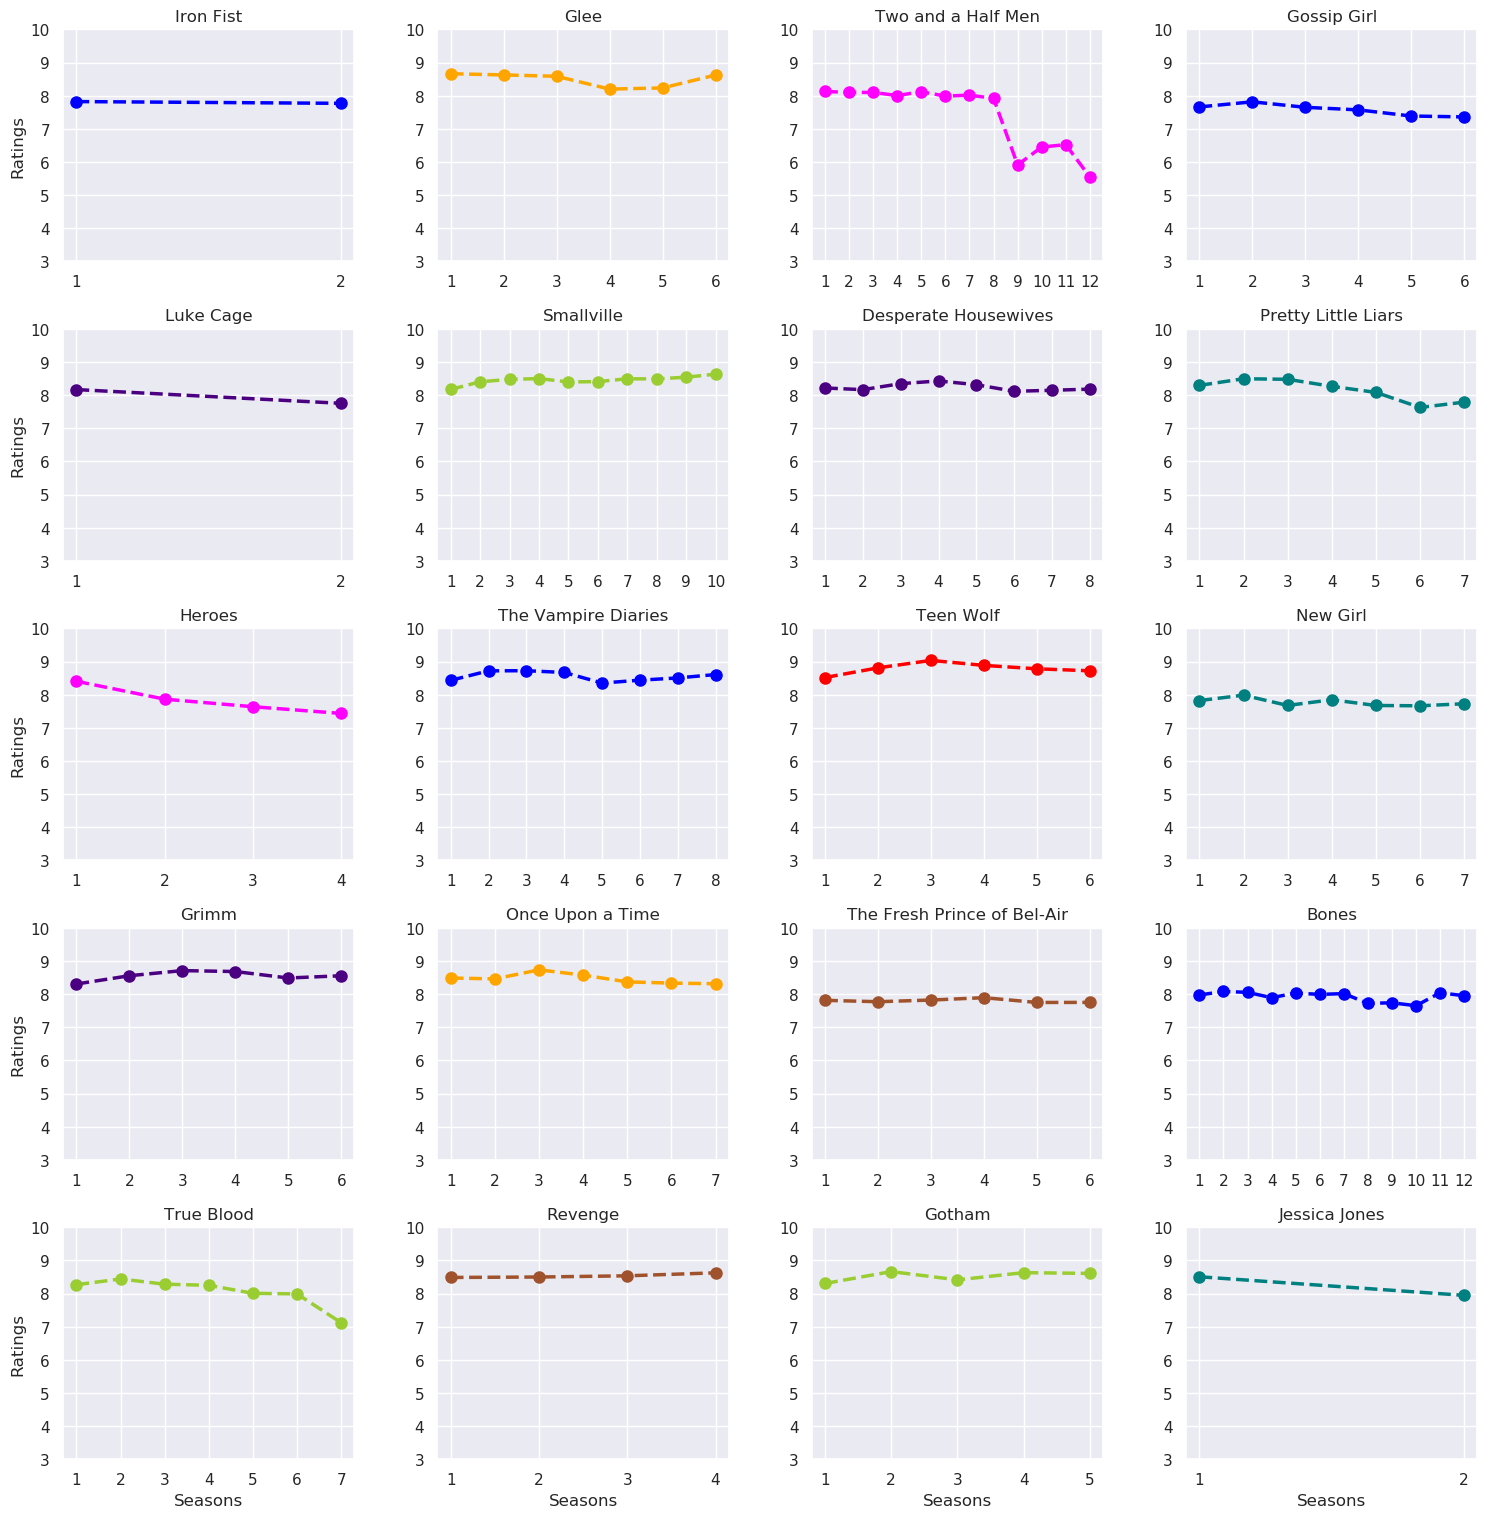

In [152]:
# plot the average rating per season for all shows

# setup
sns.set_style("darkgrid")
sns.set_context("notebook")
f, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,15))
ax = ax.ravel()
f.tight_layout(
    h_pad=2,
    w_pad=2
)

# plot the 20
for pos, show in enumerate(bottom20_tv):
    # plot
    ax[pos].plot(
        season_avg[season_avg.show == show].season_num.tolist(),
        season_avg[season_avg.show == show].rating.tolist(),
        ls="--",
        lw=2.5,
        marker="o",
        ms=8,
        color=random.choice(["red","blue","indigo","magenta","orange","sienna","teal","yellowgreen"])
    )
    
    # label
    ax[pos].set_title(show)
    ax[pos].set_xticks(season_avg[season_avg.show == show].season_num.tolist())
    ax[pos].set_yticks(range(3,11))
    if pos in [0,4,8,12,16]:
        ax[pos].set_ylabel("Ratings")
    if pos in [16,17,18,19]:
        ax[pos].set_xlabel("Seasons")

# show
plt.show()

### Episode Ratings Per Season for the Top 20 TV Shows

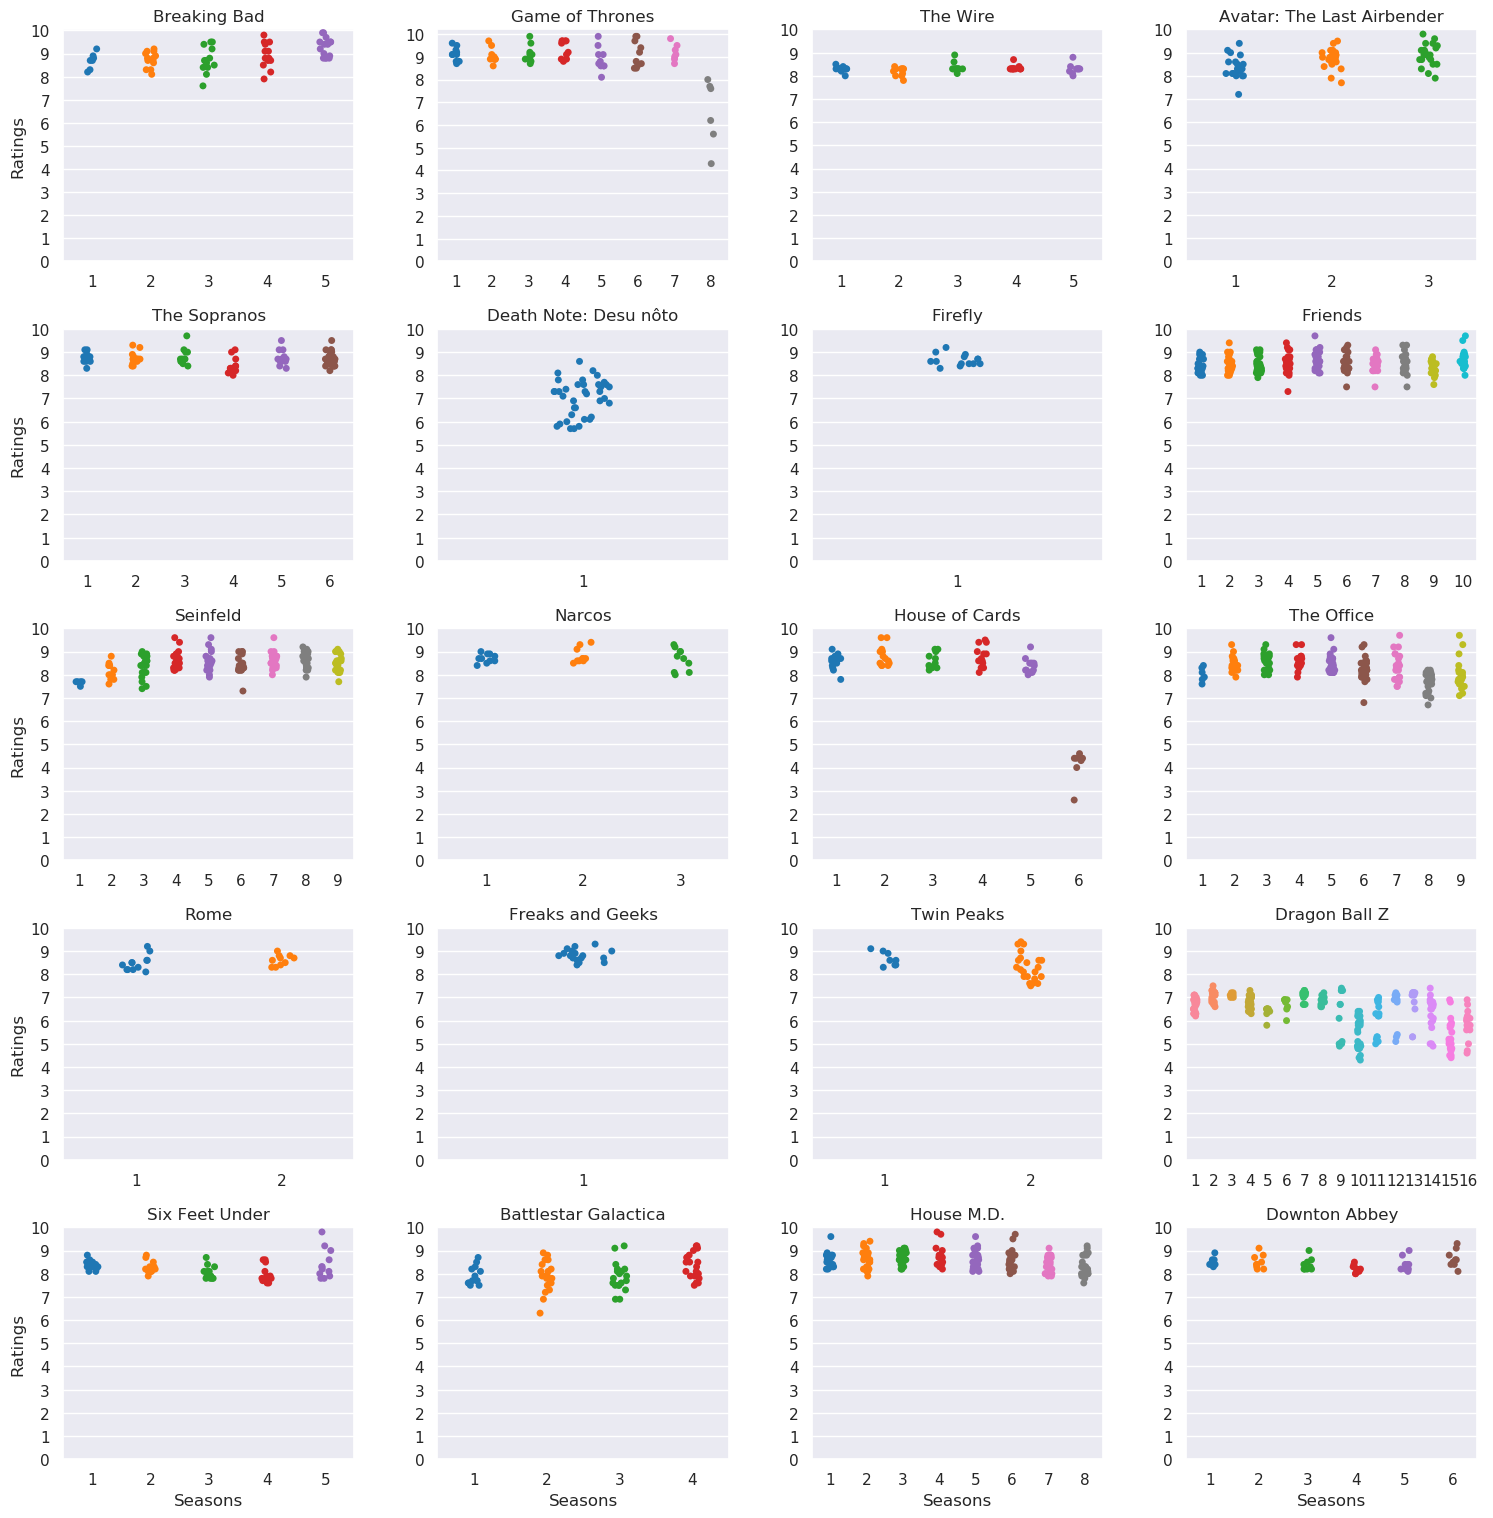

In [238]:
# plot the ratings of all episodes for each season per show

# setup
sns.set_style("darkgrid")
sns.set_context("notebook")
f, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,15))
ax = ax.ravel()
f.tight_layout(
    h_pad=2,
    w_pad=2
)

# plot the 20
for pos, show in enumerate(top20_tv):
    # plot
    vis5 = sns.stripplot(
        data=only_rated[only_rated.show == show],
        x="season_num",
        y="rating",
        ax=ax[pos]
    )
    
    # label
    vis5.set_title(show)
    vis5.set_yticks(range(0,11))
    if pos in [0,4,8,12,16]:
        vis5.set_ylabel("Ratings")
    else:
        vis5.set_ylabel("")
    if pos in [16,17,18,19]:
        vis5.set_xlabel("Seasons")
    else:
        vis5.set_xlabel("")

# show
plt.show()

### Episode Ratings Per Season for the Top 20 TV Shows

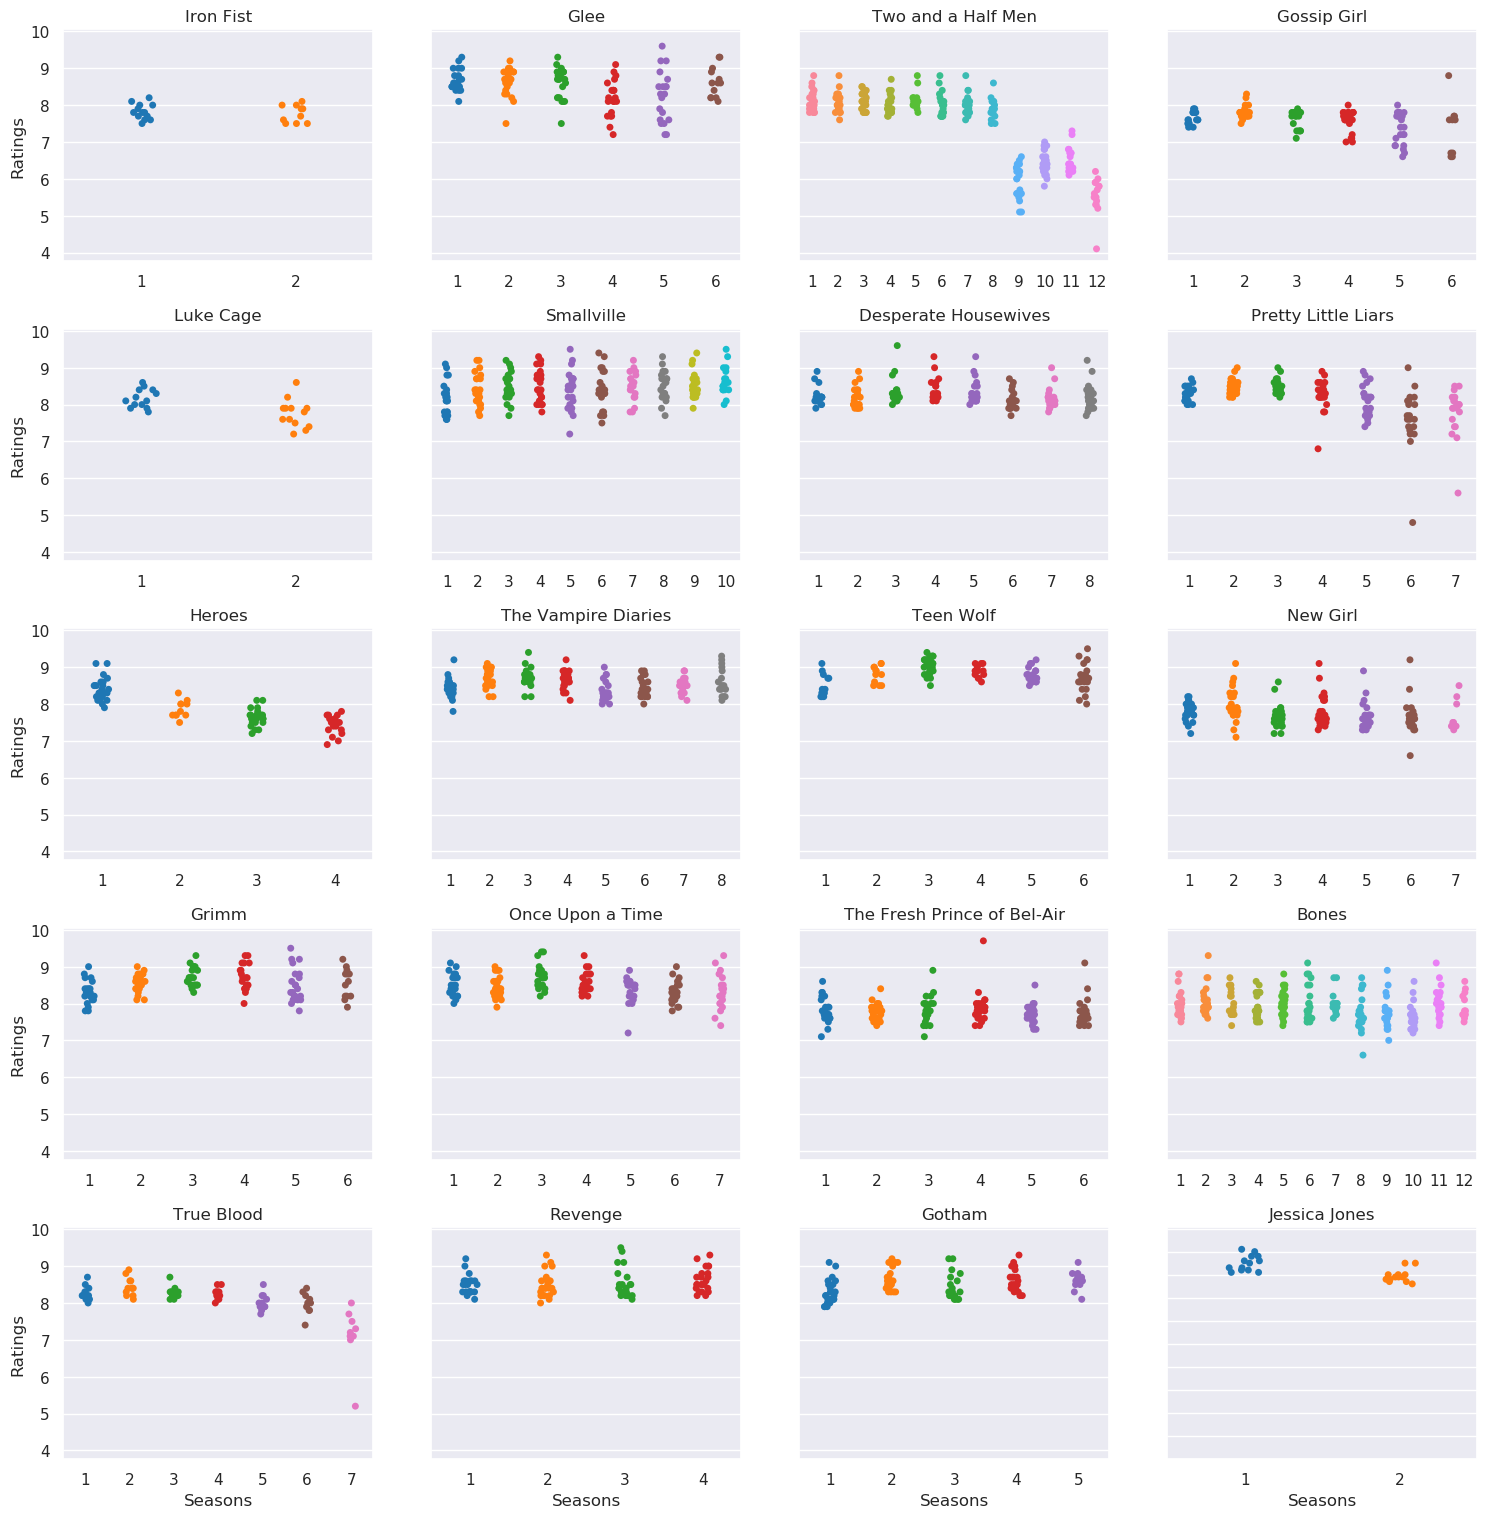

In [239]:
# plot the ratings of all episodes for each season per show

# setup
sns.set_style("darkgrid")
sns.set_context("notebook")
f, ax = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(15,15))
ax = ax.ravel()
f.tight_layout(
    h_pad=2,
    w_pad=2
)

# plot the 20
for pos, show in enumerate(bottom20_tv):
    # plot
    vis6 = sns.stripplot(
        data=only_rated[only_rated.show == show],
        x="season_num",
        y="rating",
        ax=ax[pos]
    )
    
    # label
    vis6.set_title(show)
    vis6.set_yticks(range(0,11))
    if pos in [0,4,8,12,16]:
        vis6.set_ylabel("Ratings")
    else:
        vis6.set_ylabel("")
    if pos in [16,17,18,19]:
        vis6.set_xlabel("Seasons")
    else:
        vis6.set_xlabel("")

# show
plt.show()

### Relationship Between Number of Episodes and Overall Show Rating

In [153]:
# append number of episodes to complete_shows df
episode_count = only_rated.groupby("show")["episode_number"].count().reset_index()
complete_shows = complete_shows.merge(episode_count, left_on="title", right_on="show")
complete_shows = complete_shows.drop(columns=["show"])
complete_shows = complete_shows.rename(columns={"episode_number": "num_of_episodes"})

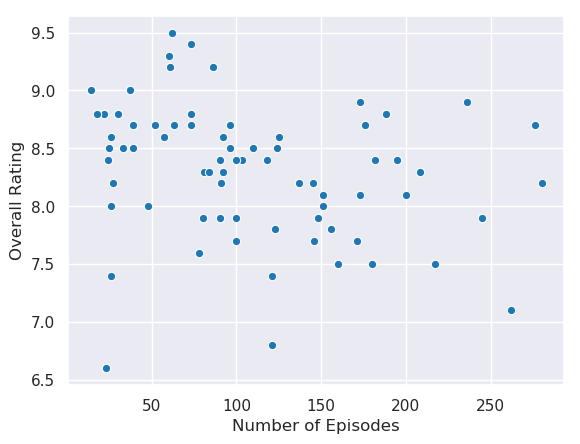

In [167]:
# plot
vis1 = sns.scatterplot(
    data=complete_shows,
    x="num_of_episodes",
    y="overall_rating"
)

# label
vis1.set_xlabel("Number of Episodes")
vis1.set_ylabel("Overall Rating")

# show
plt.show()

### Relationship Between Number of Episodes in a Season and Season Rating

In [176]:
# get number of episodes per season and season rating
season_episode_rating = only_rated.pivot_table(
    values=["episode_number", "rating"],
    index=["show", "season_num"],
    aggfunc={
        "episode_number": "count",
        "rating": "mean"
    }
).reset_index()

# rename columns
season_episode_rating = season_episode_rating.rename(columns={
    "episode_number": "num_of_episodes",
    "rating": "season_rating"
})

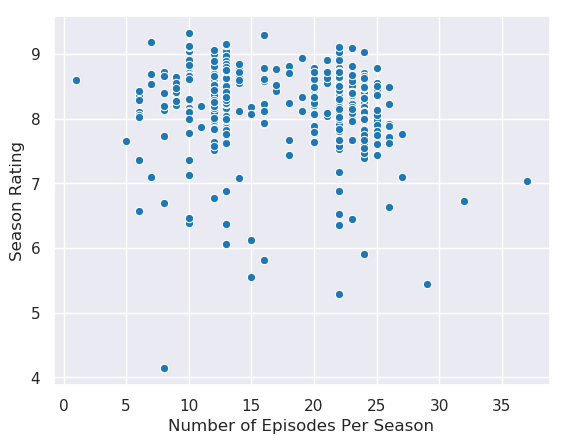

In [181]:
# plot
vis2 = sns.scatterplot(
    data=season_episode_rating,
    x="num_of_episodes",
    y="season_rating"
)

# label
vis2.set_xlabel("Number of Episodes Per Season")
vis2.set_ylabel("Season Rating")

# show
plt.show()

NOTE: Perhaps a ridiculous observation but I can't help but notice that this is heart-shaped!

### First Season Rating vs Last Season Rating

In [207]:
# get season ratings of first and last seasons for each show
first_last_ratings = []

for show in only_rated.show.unique():
    # get relevant records
    relevant_records = only_rated[only_rated.show == show]
    
    # get first and last season numbers
    first_season_num = relevant_records.season_num.min()
    last_season_num = relevant_records.season_num.max()
    
    # get first and last season ratings
    first_season_rating = relevant_records[relevant_records.season_num == first_season_num].rating.mean()
    last_season_rating = relevant_records[relevant_records.season_num == last_season_num].rating.mean()
    
    # store
    first_last_ratings.append({
        "show": show,
        "first_season": first_season_rating,
        "last_season": last_season_rating
    })
    
# turn into df
first_last_ratings = pd.DataFrame(first_last_ratings)

In [209]:
# melt into longer df for the sns boxplot function
first_last_ratings_long = first_last_ratings.melt(
    id_vars="show",
    value_vars=["first_season", "last_season"],
    var_name="season",
    value_name="rating"
)

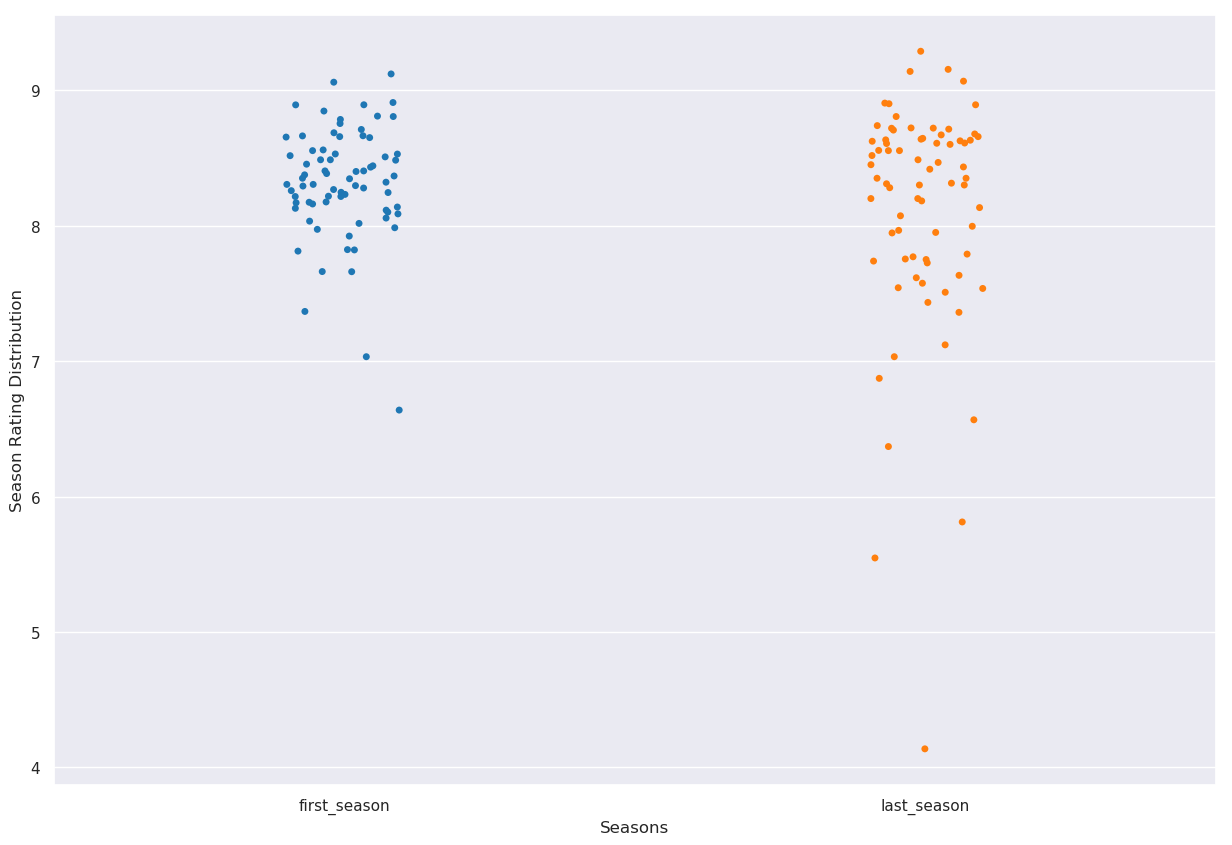

In [218]:
# plot
vis3 = sns.stripplot(
    data=first_last_ratings_long,
    x="season",
    y="rating"
)

# label
vis3.set_xlabel("Seasons")
vis3.set_ylabel("Season Rating Distribution")

# show
plt.show()